# Wstęp

Raport zawiera analizę przeżycia polskich olimpijczyków, uwzględniając sportowców biorących udział zarówno w igrzyskach letnich, jak i w zimowych. Do analizy danych posłużono się listą olimpijczyków dostępną na stronie: https://pl.wikipedia.org/wiki/Polscy_olimpijczycy, zawierającą informację o olimpijczykach biorących udział w zawodach do Zimowych Igrzysk Olimpijskich 2014 włącznie.
Celem analizy jest znalezienie powiązań między uprawianą dyscypliną sportu a długością przeżycia. 
Analiza została przeprowadzono głównie w języku Python 3 wraz z biblioteką pandas, część analizy wykonana została w języku R, co jest wyraźnie zaznaczone w tekście.

# Zgromadzenie danych

Do zebrania danych posłużono się API (wikipediaapi). Pierwszym krokiem jest pobranie zawartości strony i wyekstrahowanie z niej listy olimpijczyków, która znajduje się w oddzielnej sekcji strony.

In [278]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('pl')
page_py = wiki_wiki.page('Polscy_olimpijczycy')
print(page_py.summary[0:70])

Polscy olimpijczycy – grupa sportowców reprezentująca Polskę na igrzys


In [314]:
olimp_list = page_py.sections[1]
olimp = str(olimp_list)
olimp[180:220]

'n: A (3):\nJadwiga Abisiak – siatkówka,  '

W liście znajdują się niepotrzebne informacje (np. tytuł sekcji, podtytuły). Kolejnym krokiem jest usunięcie linii zawierających te informacje. Jak można łatwo zauważyć, linie zawierające informacje o olimpijczykach zawierają myślnik (półpauzę), więc usunięte zostaną te linie, które go nie zawierają.

In [280]:
olimp_lines = olimp.splitlines()
print(olimp_lines[7])

Jadwiga Abisiak – siatkówka,  brązowa medalistka z igrzysk w Tokio 1964


In [286]:
for line in olimp_lines:
    if '–' not in line:
        olimp_lines.remove(line)

Pierwsza i ostatnia linia po redukcji niepotrzebnych informacji wyglądają następująco:

In [287]:
print(olimp_lines[0])
print(olimp_lines[-1])

Jadwiga Abisiak – siatkówka,  brązowa medalistka z igrzysk w Tokio 1964
Piotr Żyła – skoki narciarskie, olimpijczyk z Soczi 2014


Do analizy będą niezbędne imię i nazwisko sportowca oraz dyscyplina, którą uprawia. W analizie każdemu sportowcowi została przypisana jedna, główna dyscyplina. Można zauważyć, że uprawiana dyscyplina sportu to informacja, która znajduje się po myślniku (półpauzie) a przed pierwszym napotkanym przecinkiem. Do wyekstrahowania informacji o dyscyplinie posłużyły metody pomocnicze get_index (znajdująca pozycję myślnika) i get_index_comma (znajdująca pozycje przecinków). 

In [288]:
test = olimp_lines[0]
print(test)

Jadwiga Abisiak – siatkówka,  brązowa medalistka z igrzysk w Tokio 1964


In [289]:
def get_index(x):
    ind = 0
    for i in range(len(x)):
        if x[i]=='–':
            ind = i
    return ind

In [290]:
def get_index_comma(x):
    ind = []
    for i in range(len(x)):
        if x[i]==',':
            ind.append(i)
    if len(ind)>0:
        return ind
    else:
        return [0]

Przy użyciu funkcji word_tokenize z biblioteki NLTK, zawartość tekstu danej linii zamieniana jest na listę, której elementami są słowa (fragmenty tekstu rozdzielone spacją) danej linii. 

In [291]:
import nltk
print(nltk.word_tokenize(test)[0:4])

['Jadwiga', 'Abisiak', '–', 'siatkówka']


In [293]:
get_index(nltk.word_tokenize(test))

2

In [294]:
get_index_comma(nltk.word_tokenize(test))

[4]

Za pomocą tych funkcji, z każdej linii możliwe jest wyekstrahowanie interesujących informacji. Imiona, nazwiska i dyscypliny uprawiane przez sportowców zostają zapisane w postaci struktury DataFrame biblioteki pandas, która pozwala na manipulacje danymi w prosty sposób i zapis do formatów csv i xls.

In [295]:
import pandas as pd
df = pd.DataFrame(columns = ['name', 'surname', 'discipline'])
for line in olimp_lines:
    year = []
    s = nltk.word_tokenize(line)
    name = s[0]
    ind = get_index(s)
    surname = s[1:ind]
    commas = get_index_comma(s)
    ind1 = commas[0]
    disc = s[ind+1:ind1]
    data = []
    data.append(name)
    data.append(' '.join(surname))
    data.append(' '.join(disc))
    #print(data)
    df.loc[len(df)]=data

Początkowe wiersze wyglądają następująco:

In [296]:
df.head()

,name,surname,discipline
0,Jadwiga,Abisiak,siatkówka
1,Mariola,Abrahamczyk,wioślarstwo
2,Paweł,Abratkiewicz,łyżwiarstwo szybkie
3,Kazimierz,Adach,boks
4,Stefan,Adamczak,lekkoatletyka


Struktura zawiera informacje o 2574 olimpijczykach.

Kolejną informacją, niezbędną w analizie przeżycia, jest liczba lat życia. Dla osób, które żyją, będzie to obecna liczba lat życia, natomiast dla osób, które nie żyją - liczba lat życia w momencie śmierci. Liczba lat życia obliczana będzie na podstawie dat urodzenia i śmierci, dla każdego sportowca pobieranych z odpowiadającej jemu strony. Strony osób mają postać: https://pl.wikipedia.org/wiki/Imię_Nazwisko i w takim formacie (Imię_Nazwisko) musi być podany argument funkcji get_age. Funkcja get_age zwraca 2 daty: urodzenia i śmierci.  

In [297]:
def get_age(full_name):
    born = []
    died = []
    page_py = wiki_wiki.page(full_name)
    if page_py.exists():
        summ = page_py.summary[0:300]
        summ = nltk.word_tokenize(summ)
        for i in range(len(summ)):
            if summ[i]=='ur':
                born.append(summ[i+2])
                born.append(summ[i+3])
                born.append(summ[i+4])
            if summ[i]=='zm':
                died.append(summ[i+2])
                died.append(summ[i+3])
                died.append(summ[i+4])
    return ' '.join(born), ' '.join(died)

W przypadku, gdy data urodzenia lub śmierci nie istnieje na danej stronie, funkcja zwraca pusty string:

In [298]:
get_age("Piotr_Żyła")

('16 stycznia 1987', '')

W strukturze z danymi sportowców dodane zostały kolumny: full_name (Imię_Nazwisko), born (początkowo pusty string, docelowo data urodzenia), died (początkowo pusty string, docelowo data śmierci).

In [300]:
import re
df1 = df
df1['full_name'] = df1['name'] + " " + df1['surname']
df1['full_name'] = df1['full_name'].apply(lambda x: 
                                          re.sub(r"\s", "_", x))
df1['born'] = ""
df1['died'] = ""
df1[['full_name', 'born', 'died']].head()

,full_name,born,died
0,Jadwiga_Abisiak,,
1,Mariola_Abrahamczyk,,
2,Paweł_Abratkiewicz,,
3,Kazimierz_Adach,,
4,Stefan_Adamczak,,


Dla każdego rzędu, dla którego strona sportowca istnieje, używając wartości w kolumnie full_name jako argumentu funkcji get_age, pobrane zostały wartości dat urodzenia i śmierci. 

In [ ]:
for index, row in df1.iterrows():
    try:
        row['born']= get_age(row['full_name'])[0]
        row['died']= get_age(row['full_name'])[1]
    except:
        pass

In [52]:
df1 = df1[['name', 'surname', 'born', 'died']]
df1.head()

,name,surname,discipline,born,died
0,Jadwiga,Abisiak,siatkówka,2 lutego 1934,19 czerwca 2004
1,Mariola,Abrahamczyk,wioślarstwo,3 października 1958,NaN
2,Paweł,Abratkiewicz,łyżwiarstwo szybkie,10 czerwca 1970,NaN
3,Kazimierz,Adach,boks,9 maja 1957,NaN
4,Stefan,Adamczak,lekkoatletyka,27 listopada 1892,NaN


# Czyszczenie i przygotowanie danych

## Uzupełnienie brakujących danych

Struktura df2 zawiera informacje o osobach, dla których nie znaleziono daty urodzenia:

In [305]:
df1 = df1.fillna(value = 'nan')
df2 = df1[df1.born=='nan']

Ze struktury df1 zostały usunięte wiersze, w których nie znaleziono daty urodzenia:

In [54]:
df1 = df1[df1.born!='nan']

In [55]:
df1.shape

(2258, 5)

Po tej operacji w strukturze pozostało 2258 z 2574 olimpijczyków, dla których znaleziono informacje.

Imiona i nazwiska ze struktury df2 (nieznalezione) zostały zapisane w pliku names.txt. 

In [56]:
names = df2.name + "_" + df2.surname
names.to_csv('names.txt', sep=',')

Dla części olimpijczyków data nie została znaleziona, ponieważ strona odnosząca się tylko do imienia i nazwiska spotowca nie istnieje. Strona dla danego olimpijczyka może w ogóle nie istnieć, natomiast jest także możliwe, że istnieje kilka osób o tym samym nazwisku i z tego względu strona dla olimpijczyka ma inną postać (bardziej szczegółową).
Na stronie zawierającej listę polskich olimpijczyków znajdują się odnośniki do stron dla poszczególnych olimpijczyków. 
Dla każdego olimpijczyka, którego imię i nazwisko znajdują się w pliku names.txt, wyekstrahowany został odnośnik z głównej strony (gdzie jako główną stronę rozumiemy stronę zawierającą pełną listę olimpijczyków). Następnie ten odnośnik został użyty jako argument funkcji get_age, żeby pobrać informacje o datach urodzenia i śmierci z właściwej strony.

W tym celu w języku Python 2 został napisany crawler (crawl.py), który pozwala na pobranie zawartości strony:

In [ ]:
import urllib2
import sys
def download(url):
	print 'Downloading:', url
	try:
		html = urllib2.urlopen(url).read()
	except urllib2.URLError as e:
		print 'Download error:', e.reason
		html = None
	return html

d = download(sys.argv[1])
print d

Następnie dla każdego sportowca został wyekstrahowany odnośnik używając wyrażeń regularnych. Przykład użycia:

In [ ]:
ekot@ekot:~/praktyki$ python crawl.py 
        https://pl.wikipedia.org/wiki/Polscy_olimpijczycy | 
        grep -oP "Janusz_Zalewski_\(.+?\)"


Janusz_Zalewski_(%C5%BCeglarz)

Dla każdego sportowca z pliku names.txt został znaleziony jego odnośnik, jeżeli istnieje. Wyniki zostały zapisane w pliku extended.csv.

In [57]:
ex = pd.read_csv('extended.csv')
ex.head()

,NAME
0,Jerzy_Adamski_(bokser)
1,Tadeusz_Adamski_(hokeista_na_trawie)
2,Bernard_Aluchna
3,Zdzisław_Antczak_(piłkarz_ręczny)
4,Elżbieta_Apostolska


Odnośniki znalezione na stronie za pomocą crawlera, zostały zapisane w strukturze df2 w kolumnie full_name.

In [ ]:
df2 = df2.reset_index()
df2['full_name'] = df2['name'] + " " + df2['surname']
df2['full_name'] = df2['full_name'].apply(lambda x: re.sub(r"\s", "_", x))

In [64]:
df2.head()

,level_0,index,name,surname,discipline,born,died,full_name
0,0,12,Jerzy,Adamski,boks,nan,nan,Jerzy_Adamski
1,1,13,Tadeusz,Adamski,hokej na trawie,nan,nan,Tadeusz_Adamski
2,2,20,Bernard,Aluchna,pływanie,nan,nan,Bernard_Aluchna
3,3,29,Zdzisław,Antczak,piłka ręczna,nan,nan,Zdzisław_Antczak
4,4,33,Elżbieta,Apostolska,gimnastyka sportowa,nan,nan,Elżbieta_Apostolska


In [78]:
df2['new_name'] = None

Następnie sprawdzono, czy znaleziony na stronie odnośnik różni się od tego opartego tylko o imię i nazwisko, którego użyto wcześniej przy wyszukiwaniu danych.

In [306]:
for index, row in df2.iterrows():
    for exname in ex.NAME:
        tmp = re.findall(r"[A-Z].+?_",exname)
        tmp = "".join(tmp)
        tmp = tmp[:-1]
        if tmp == row['full_name']:
            row["full_name"]=exname
            if df2.new_name.iloc[index] == None:
                df2.new_name.iloc[index] = exname
            else:
                df2.new_name.iloc[index] = df2.new_name.iloc[index] 
                + "," + exname

W strukturze df3 wpisano wartości, dla których znaleziono wyłącznie nowe odnośniki do stron.

In [95]:
df3 = df2[df2.new_name!='nan']
df3 = df3[['name', 'surname', 'discipline', 'born', 'died', 'new_name']]
df3.head()

,name,surname,discipline,born,died,new_name
0,Jerzy,Adamski,boks,nan,nan,Jerzy_Adamski_(bokser)
1,Tadeusz,Adamski,hokej na trawie,nan,nan,Tadeusz_Adamski_(hokeista_na_trawie)
3,Zdzisław,Antczak,piłka ręczna,nan,nan,Zdzisław_Antczak_(piłkarz_ręczny)
5,Rafał,Augustyn,lekkoatletyka,nan,nan,Rafał_Augustyn_(lekkoatleta)
13,Jacek,Bednarek,lekkoatletyka,nan,nan,Jacek_Bednarek_(lekkoatleta)


In [96]:
df3 = df3.reset_index()

In [97]:
df3.shape

(197, 7)

Dla 197 z 316 sportowców znaleziono odnośnik do nowej strony. Korzystając z odnośnika jako argumentu funkcji get_age, uzupełnione zostały kolejne wartości dat urodzenia i śmierci.
Imiona i nazwiska, dla których nie znaleziono dat lub odnośnika na stronie, zapisano odpowiednio w plikach nieznalezione2.csv i nieznalezione1.csv.

In [91]:
df4 = df2[df2.new_name=='nan']

In [309]:
for index, row in df3.iterrows():
    try:
        df3.born.iloc[index]= get_age(row['new_name'])[0]
        df3.died.iloc[index]= get_age(row['new_name'])[1]
    except:
        pass

In [103]:
df4.to_csv('nieznalezione1.csv')

In [102]:
df3[df3.born==''].to_csv('nieznalezione2.csv')

In [104]:
df3 = df3[df3.born!='']

In [107]:
df3.head()

,index,name,surname,discipline,born,died,new_name
0,0,Jerzy,Adamski,boks,14 marca 1937,6 grudnia 2002,Jerzy_Adamski_(bokser)
1,1,Tadeusz,Adamski,hokej na trawie,19 lipca 1922,28 grudnia 2001,Tadeusz_Adamski_(hokeista_na_trawie)
2,3,Zdzisław,Antczak,piłka ręczna,20 listopada 1947,,Zdzisław_Antczak_(piłkarz_ręczny)
3,5,Rafał,Augustyn,lekkoatletyka,14 maja 1984,,Rafał_Augustyn_(lekkoatleta)
4,13,Jacek,Bednarek,lekkoatletyka,27 stycznia 1964,,Jacek_Bednarek_(lekkoatleta)


Dla nieznalezionych osób (129 imion i nazwisk) ręcznie dokonano poprawek, żeby jeszcze raz pobrać liczbę lat życia danej osoby. Nieznalezienie daty wiąże się z brakiem dat dostępnych na stronie sportowca, niespójnością wpisów w Wikipedii (zarówno zawartością samych wpisów jak i brakiem konsekwencji w używaniu znaków jak pauza, półpauza, dywiz) bądź wpisem informacji o sportowcu pod innym nazwiskiem, niż jest podane na liście (tyczy się to kobiet, które mają nazwisko dwuczłonowe, a w Wikipedii ich dane są podane na stronie z odnośnikiem zawierającym jeden człon). Poprawione dane z obu dokumentów znajdują się w pliku nieznalezione.csv. Znalezione do tej pory dane znajdują się w strukturach df1 i df3, w sumie dane dla 2445 sportowców:

In [112]:
df1.shape[0] + df3.shape[0]

2445

Dla nieznalezionych osób, których dane zostały poprawione, ponownie użyto funkcji get_age w celu znalezienia dat urodzenia i śmierci.

In [136]:
df5 = pd.read_csv('nieznalezione.csv')

In [312]:
for index, row in df5.iterrows():
    try:
        if row['new_name']!='-':
            df5.born.iloc[index]= get_age(row['new_name'])[0]
            df5.died.iloc[index]= get_age(row['new_name'])[1]
        else:
            df5.born.iloc[index]= get_age(row['name']+
                                          "_"+row['surname'])[0]
            df5.died.iloc[index]= get_age(row['name']+
                                          "_"+row['surname'])[1]            
    except:
        print(row['name'], row['surname'])

In [143]:
df5.to_csv('nieznalezione.csv')

In [201]:
df5 = pd.read_csv('nieznalezione.csv')
df5.head()

,name,surname,discipline,born,died
0,Józef,Błaszczyk,żeglarstwo,1947,NaN
1,Paweł,Borkowski,wioślarstwo,1959,NaN
2,Witold,Gadomski,szermierka,1967,NaN
3,Dariusz,Jabłoński,zapasy,1973,NaN
4,Piotr,Jabłoński,zapasy,1975,NaN


In [202]:
df5.shape

(128, 5)

Zawartość struktur df1, df3 i df5 została połączona, żeby uzyskać pełną listę.

In [313]:
frames = [df1, df3, df5]
res = pd.concat(frames, ignore_index=True)
res = res.sort_values(by='surname')
res = res[['name', 'surname', 'born', 'died', 'discipline']]

Następnie z zawartości kolumn born i died został wyekstrahowany jedynie rok.

In [204]:
d = res

In [205]:
d['born'] = d['born'].apply(lambda x: x[-4:])

In [206]:
d['died']=d['died'].fillna('NONE')

In [207]:
d.head()

,name,surname,born,died,discipline
0,Jadwiga,Abisiak,1934,19 czerwca 2004,siatkówka
1,Mariola,Abrahamczyk,1958,nan,wioślarstwo
2,Paweł,Abratkiewicz,1970,nan,łyżwiarstwo szybkie
3,Kazimierz,Adach,1957,nan,boks
4,Stefan,Adamczak,1892,nan,lekkoatletyka


In [208]:
d['died'] = d['died'].apply(lambda x: x[-4:])

In [209]:
d.head()

,name,surname,born,died,discipline
0,Jadwiga,Abisiak,1934,2004,siatkówka
1,Mariola,Abrahamczyk,1958,nan,wioślarstwo
2,Paweł,Abratkiewicz,1970,nan,łyżwiarstwo szybkie
3,Kazimierz,Adach,1957,nan,boks
4,Stefan,Adamczak,1892,nan,lekkoatletyka


Do struktury dodana została także kolumna sex, w której jest zawarta informacja o płci - "M" w przypadku mężczyzn i "F" w przypadku kobiet.
W zależności od ostatniej litery imienia, w kolumnie sex przypisana została odpowiednia płeć.
W przypadku Li Qian, która jest obcego pochodzenia, ta zasada nie obowiązuje i przypisana została do niej wartość "F" w kolumnie sex.
Przypadkiem spornym jest Stanisława Walasiewicz, u której sekcja zwłok wykazała obecność narządów płciowych obu płci. W celu zapewnienia spójności danych, rekord z informacjami o niej został usunięty.

In [40]:
d['sex'] = d['name'].apply(lambda x: 'F' if x[-1]=='a' 
                           or x=='Li' else 'M')
d.head()

,name,surname,born,died,discipline,sex,age
0,Julian,Michaux,1867,1925.0,szermierka,M,58.0
1,Stanisław,Wróblewski,1868,1938.0,zapasy,M,70.0
2,Walery,Maryański,1875,1946.0,strzelectwo,M,71.0
4,Konrad,Winkler,1882,1962.0,szermierka,M,80.0
5,Wacław,Okulicz-Kozaryn,1884,1974.0,zapasy,M,90.0


In [211]:
d.shape

(2573, 6)

Lista została zapisana w pliku result.csv.

In [212]:
d.to_csv('result1.csv')

In [76]:
import pandas as pd
d = pd.read_csv('result.csv')

Dla sportowców, dla których pobranie dat się nie powiodło, uzupełniono dane ręcznie na podstawie danych dostępnych w Wikipedii. Takie rozwiązanie było szybsze niż automatyzacja - różnorodność błędów (w zapisie, nazwiskach, zawartości stron) była zbyt duża, żeby parsowanie automatyczne usprawniło czas.
Dla Franciszki Pietrzykowskiej nie znaleziono danych o datach urodzenia i śmierci. Jest to olimpijka, która brała udział w igrzyskach olimpijskich w 1908 roku. Danych nie znaleziono także dla Waldemara Woźniaka, dla którego odnośnik w Wikipedii był błędny (do strony malarza o tym samym imieniu i nazwisku) i który nie ma własnej, dedykowanej strony. Informacji nie znaleziono także dla Wacława Michalskiego, którego daty urodzenia i śmierci są nieznane, co jest zaznaczone na jego stronie w Wikipedii. Rekordy z tymi 3 olimpijczykami usunięto.
Dla 11 sportowców znana jest data ich urodzenia, natomiast nieznana była data ich śmierci. Każda z tych osób urodziła się między rokiem 1877 a 1916 włącznie, brak wiedzy o dacie ich śmierci jest spowodowany wojną. W kolumnie died dla tych osób wpisano 0, żeby odróżnić ich od braku informacji ('nan') w przypadku osób, które żyją do tej pory.

In [77]:
d.shape

(2571, 6)

Zgromadzono informacje o 2571 olimpijczykach, w tym o 11, których data śmierci jest nieznana:

In [78]:
d[d.died==0]

,name,surname,born,died,discipline,sex
3,Edward,Bryzemejster,1877,0.0,żeglarstwo,M
15,Kazimierz,Żebrowski,1891,0.0,hokej na lodzie,M
21,Oswald,Miller,1892,0.0,kolarstwo szosowe,M
64,Jerzy,Łucki,1898,0.0,bobsleje,M
106,Józef,Łaszewski,1901,0.0,wioślarstwo,M
134,Stanisław,Ziffer,1904,0.0,lekkoatletyka,M
152,Leon,Rękawek,1905,0.0,zapasy,M
232,Józef,Szajba,1910,0.0,żeglarstwo,M
237,Anna,Breuer-Mosler,1911,0.0,lekkoatletyka,F
253,Roman,Kantor,1912,0.0,szermierka,M


Rekordy tych sportowców zostały usunięte ze struktury:

In [79]:
d = d[d.died!=0]

In [80]:
d.shape

(2560, 6)

W ten sposób uzyskano dane zgodne z informacją w Wikipedii dla 2560 z 2574 sportowców.

## Wyekstrahowanie liczby lat życia

In [81]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Rok urodzenia każdego ze sportowców zamieniono na wartość numeryczną, jeśli występowała w nim inna wartość. Na histogramie przedstawiono rozkład lat urodzenia. 

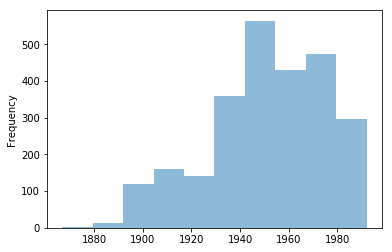

In [82]:
d['born']=pd.to_numeric(d['born'], errors='coerce')
d['born'].plot.hist(alpha=0.5)

W analogiczny sposób zamieniono wartości daty śmierci.

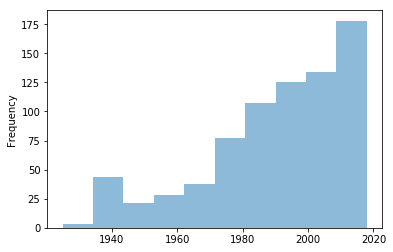

In [85]:
d['died']=pd.to_numeric(d['died'], errors='coerce')
d['died'].plot.hist(alpha=0.5)

W olimpiadach bierze udział coraz większa liczba osób, dlatego w kolejnych latach liczba śmierci jest też coraz wyższa. Możemy zauważyć, że ta tendencja jest zaburzona w okolicach roku 1940. W tamtym czasie większa liczba olimpijczyków zmarła ze względu na wybuch II wojny światowej.

Do struktury dodano kolumnę z informacją o liczbie lat życia ("age"). Wartość w kolumnie to różnica między wartościami w kolumnach "died" i "born".

In [86]:
d['age']=d['died']-d['born']
d.sample(5)

,name,surname,born,died,discipline,sex,age
1083,Adam,Brodecki,1949,2010.0,łyżwiarstwo figurowe,M,61.0
1623,Dorota,Załęczna,1961,NaN,hokej na trawie,F,NaN
321,Tadeusz,Świcarz,1920,2002.0,hokej na lodzie,M,82.0
1130,Wiesław,Hartman,1950,NaN,jeździectwo,M,NaN
12,Franciszek,Brożek,1890,1940.0,strzelectwo,M,50.0


Dla osób, które obecnie żyją, data śmierci nie istnieje. W kolumnie "died" wartości nieznane zostały zamienione na 0, następnie w kolumnie "age" liczba lat życia został wpisana jako różnica między wartościami w kolumnach "died" i "born". Dla obecnie żyjących osób ta wartość jest ujemna (0 - rok urodzenia). W ich przypadku wartość zostaje zamieniona na 2018+obecna wartość (czyli 2018 - rok urodzenia). 

In [87]:
d['died'] = d['died'].apply(lambda x: 0 if np.isnan(x) 
                            else x)
d['age']=d['died']-d['born']
d['age'] = d['age'].apply(lambda x: 2018+x if x<0 
                          else x)

In [328]:
d[['name', 'surname', 'born', 'died', 'age']].sample(5)

,name,surname,born,died,age
2434,Kazimierz,Lipień,1949,2005,56
2440,Marek,Galiński,1951,1999,48
730,Kunegunda,Godawska,1951,0,67
360,Robert,Góralczyk,1943,1984,41
1779,Andrzej,Kozłowski,1968,0,50


## Informacja o śmierci

W strukturze została dodatkowa kolumna ("E"), która mówi o tym, czy śmierć nastąpiła, czy nie. Jest to informacja potrzebna w dalszej analizie.

In [330]:
d['E'] = d['died'].apply(lambda x: 0 if x==0 else 1)
d[['name', 'surname', 'born', 'died', 'E']].sample(5)

,name,surname,born,died,E
2328,Wiesława,Kiełsznia-Buksińska,1961,0,0
2118,Zbigniew,Matwiejew,1949,0,0
964,Eugeniusz,Lokajski,1908,1944,1
1843,Jerzy,Szymczyk,1942,2016,1
1868,Wiesław,Czaja,1952,0,0


## Podział na dyscypliny

In [317]:
len(d.discipline.unique())

48

Olimpijczycy są przypisani do jednej z 48 dyscyplin. Dyscypliny zostały podzielone na grupy (za pomocą odpowiedniego kodu dyscypliny w kolumnie "code"), według następującego podziału:
1 - dyscypliny wytrzymałościowe - np. maraton, biegi długie i średnie, chód, gry zespołowe,
2 - dyscypliny siłowo-wytrzymałościowe - np. wioślarstwo, kajakarstwo, kolarstwo szosowe, łyżwiarstwo powyżej 1500 m., biegi narciarskie, pływanie 200 - 1500 m., 
3 - dyscypliny szybkościowo-siłowe - np. biegi krótkie do 400 m., skoki, łyżwiarstwo szybkie, pływanie do 400 m., saneczkarstwo, gimnastyka sportowa,
4 - dyscypliny siłowe - np. podnoszenie ciężarów, boks, judo, zapasy,
5 - lekkoatletyka.
Dodatkowo, jeżeli dyscyplina nie została przypisana do żadnej z tej kategorii, w kolumnie "code" występuje wartość 0. W przypadku dyscyplin takich jak pływanie czy narciarstwo alpejskie, które odbywają się na wielu dystansach, a przez to mogą należeć do różnych grup, w kolumnie "code" przypisano wartość 0.
Lista z przypisaniami znajduje się w pliku result_codes.csv.

In [96]:
d = pd.read_csv('result_codes.csv')
tmp = d.groupby('code')['age']
tmp.describe()

,count,mean,std,min,25%,50%,75%,max
code,,,,,,,,
0,561.0,57.664884,17.256313,25.0,43.0,57.0,72.0,99.0
1,543.0,61.685083,14.662447,24.0,49.0,62.0,72.0,98.0
2,499.0,58.028056,16.578498,20.0,44.0,58.0,69.5,98.0
3,217.0,57.548387,18.675561,28.0,39.0,60.0,72.0,93.0
4,327.0,58.914373,15.301831,22.0,48.5,59.0,70.0,94.0
5,413.0,59.786925,17.058811,25.0,45.0,61.0,72.0,97.0


W kolumnie count znajduje się informacja o liczbie olimpijczyków należących do danego kodu dyscypliny.

# Analiza przeżycia

## Porównanie płci

Ze struktury (DataFrame) d na podstawie kolumny "E" zostały wydzielone 2 nowe struktury - d1 (osoby, które nie żyją) i d0 (osoby, które żyją).

In [101]:
d1 = d[d['E']==1]
d0 = d[d['E']==0]

In [102]:
len(d0), len(d1)

(1805, 755)

1805 osób w zbiorze ma wartość 0 w kolumnie "E" (żyje), 755 osób nie żyje.

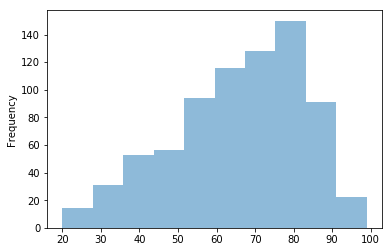

In [105]:
d1['age'].plot.hist(alpha=0.5)

Histogram przedstawia rozkład liczby lat życia, dla osób, które nie żyją.

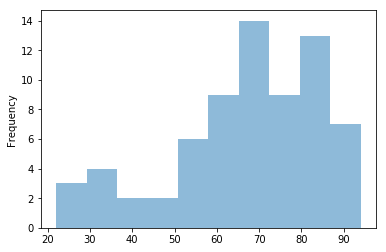

In [110]:
d1[d1['sex']=='F']['age'].plot.hist(alpha=0.5, bins=10)

Histogram przedstawia rozkład liczby lat życia dla kobiet, które nie żyją. Możemy zauważyć 2 maksima w rozkładzie, które sugerują, że rozkład może być bimodalny (pierwsze w okolicy 30 roku życia, drugie w okolicy 70 roku życia). Zmiana liczby słupków (beanów) na mniejszą nie sprawiła, że pozostało tylko jedno, wyraźne maksimum.

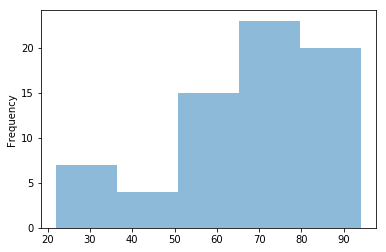

In [112]:
d1[d1['sex']=='F']['age'].plot.hist(alpha=0.5, bins=5)

W celu sprawdzenia, czy rozkład jest bimodalny, użyto testu Hartiganów. Do sprawdzenia rozkładu została użyta implementacja testu dostępna w języku R, w pakiecie diptest. 

In [108]:
d1[d1['sex']=='F']['age'].to_csv('diptestf.csv')

In [109]:
len(d1[d1['sex']=='F']['age'])

69

Test nie wykluczył hipotezy, że rozkład jest unimodalny (p-value jest większe niż 0,05). Kobiet, które nie żyją, jest tylko 69, więc histogram może przypadkowo przypominać rozkład bimodalny.

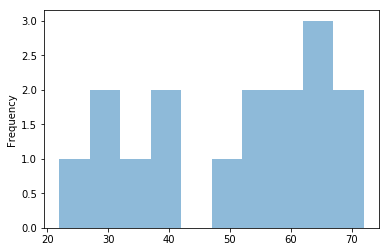

In [318]:
d1[d1.born > 1945][d1['sex']=='F']['age'].plot.hist(alpha=0.5, bins=10)

Podobnie dla podzbiorów kobiet, np. kobiet urodzone po 1945 roku, rozkład przypomina bimodalny. Rozkład mógłby sugerować, że wśród kobiet uprawiających sport istnieje pewna grupa, która umiera młodo. Testy Hartiganów ponownie nie wykluczyły, że podobieństwo do rozkładu bimodalnego jest przypadkowe.

In [319]:
d1[d1.born > 1945][d1['sex']=='F']['age'].to_csv('diptestf1945.csv')

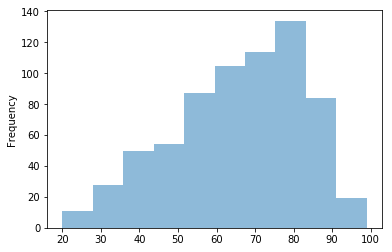

In [114]:
d1[d1['sex']=='M']['age'].plot.hist(alpha=0.5, bins=10)

Histogram dla mężczyzn jest unimodalny, co potwierdził także test Hartiganów:

In [115]:
d1[d1['sex']=='M']['age'].to_csv('diptestm.csv')

In [ ]:
> dip.test(d)

	Hartigans' dip test for unimodality / multimodality

data:  d
D = 0.016545, p-value = 0.2378
alternative hypothesis: non-unimodal, i.e., at least bimodal

In [123]:
len(d1[d1['sex']=='M']['age'])

686

### Estymator Kaplana-Meiera

Estymator Kaplana-Meiera pozwala na prognozowanie funkcji przeżycia. Jest stosowany głównie w statystyce medycznej. W naszym przypadku może być również zastosowany, ze względu na to, że pozwala na prognozowanie funkcji w oparciu o dane "urwane". Daną "urwaną" w tym przypadku jest liczba lat życia, dla większości sportowców (1805 z 2560) nie mamy informacji o dacie śmierci. Estymator Kaplana-Meiera jest dostępny w bibliotece lifelines w języku Python 3 (https://lifelines.readthedocs.io/en/latest/Quickstart.html). Po zaimportowaniu biblioteki, estymator został użyty do porównania liczby lat życia dla kobiet i mężczyzn. Struktura dm zawiera informacje o mężczyznach, struktura df o kobietach.

In [131]:
from lifelines import KaplanMeierFitter

dm = d[d.sex=='M']
df = d[d.sex=='F']

Estymator potrzebuje do prognozy tabeli z długościami trwania zdarzenia (w naszym przypadku kolumna "age" oznaczająca liczbę lat życia) oraz tabeli określającej, czy zdarzenie (śmierć) miało miejsce (kolumna "E"). Procedura jest następująca: dla każdej z grup tworzymy estymator (KaplanMeierFitter()), a następnie przy dopasowaniu jako argumenty wprowadzamy tabele z informacjami o długości życia i o wystąpieniu śmierci dla danej grupy.

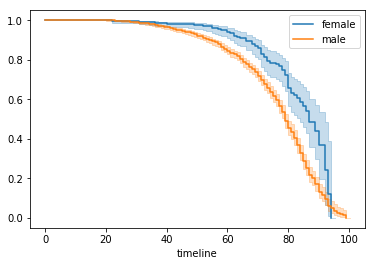

In [134]:
kmfm = KaplanMeierFitter()
kmff = KaplanMeierFitter()
Tmale = dm['age']
Emale = dm['E']
kmfm.fit(Tmale, Emale, label='male')

Tfemale = df['age']
Efemale = df['E']
kmff.fit(Tfemale, Efemale, label='female')
ax = kmff.plot()
kmfm.plot(ax=ax)

Oś X reprezentuje długość życia, oś Y - jaka część osób dożywa danego wieku. Możemy zauważyć, że dla kobiet (etykieta "female") wykres jest przesunięty w prawo - więcej osób dożywa późnego wieku.

Do sprawdzenia, czy różnica między grupami jest istotna statystycznie, można się posłużyć nieparametrycznym testem logrank. Test logrank także jest dostępny w bibliotece lifelines. Test przyjmuje tablice z długością życia i z informacją o wystąpieniu śmierci dla obu grup (4 argumenty). Hipoteza zerowa zakłada, że nie ma różnicy między grupami.

In [138]:
from lifelines.statistics import logrank_test
results = logrank_test(Tmale, Tfemale, 
                       event_observed_A=Emale, 
                       event_observed_B=Efemale)
results.print_summary()

print(results.test_statistic) 
print("p-value:", results.p_value)


df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p     
       36.0719 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
36.07191582329491
p-value: 1.901679182101648e-09


Wartość p-value jest mniejsza od 0,05, więc możemy odrzucić hipotezę zerową (brak różnicy między grupami). Taki rezultat nie jest zaskakujący ze względu na to, że kobiety statystycznie żyją dłużej niż mężczyźni, a w teście wzięliśmy pod uwagę płeć. 

## Porównanie grup dyscyplin

Struktura dd jest listą, której kolejne elementy to części struktury d zawierające ten sam kod dyscypliny (kolumna "code"). Jej pierwszym elementem są dane zawierające informacje o dyscyplinach z kodem 0, kolejnym z kodem 1 itd., aż do kodu 5.

In [139]:
dd = []
for i in range(0,6):
    tmp = d[d.code == i]
    dd.append(tmp)

W bibliotece lifelines dostępny jest także wielowymiarowy test logrank (multivariate logrank), który testuje hipotezę, że wszystkie grupy mają tę samą funkcję "przeżywalności". Metoda multivariate_logrank_test przyjmuje 3 argumenty: tablicę z czasem trwania (liczbą lat życia), tablice odpowiadającą za rozróżnienie grup (w naszym przypadku kod dyscypliny, kolumna "code") i tablicę z informacją o wystąpieniu zdarzenia (śmierci).

In [142]:
from lifelines.statistics import multivariate_logrank_test

results = multivariate_logrank_test(d['age'], d['code'], d['E'])
results.print_summary()
print("p-value:",results.p_value)


df=5, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p    
       19.9281 0.0013  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
p-value: 0.0012891795996934072


Wartość p-value jest mniejsza od 0,05, co oznacza, że nieprawdą jest, że wszystkie grupy dyscyplin mają tę samą funkcję przeżycia.

Wielowymiarowy test logrank został przeprowadzony także osobno dla kobiet i dla mężczyzn.

Dla kobiet:

In [144]:
results = multivariate_logrank_test(df['age'], df['code'], df['E'])
results.print_summary()
print("p-value:",results.p_value)


df=5, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        5.9544 0.3107
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
p-value: 0.3106833201385499


Dla mężczyzn:

In [145]:
results = multivariate_logrank_test(dm['age'], dm['code'], dm['E'])
results.print_summary()
print("p-value:",results.p_value)


df=5, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        7.6127 0.1789
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
p-value: 0.17891021302551666


Wartości p-value wielowymiarowego testu logrank przeprowadzonego osobno dla każdej płci są większe od 0,05, więc w ramach tej samej płci można odrzucić hipotezę, że funkcje przeżycia między są różne dla różnych grup dyscyplin.

Podobnie jak w przypadku płci, można porównywać ze sobą 2 grupy dyscyplin o różnych kodach:

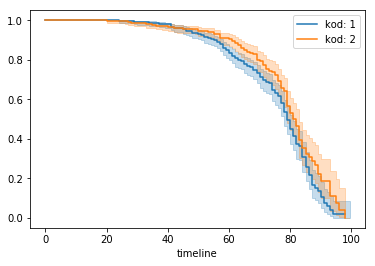

In [160]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
T1 = dd[1]['age']
E1 = dd[1]['E']
kmf1.fit(T1, E1, label='kod: 1')

T2 = dd[2]['age']
E2 = dd[2]['E']
kmf2.fit(T2, E2, label='kod: 2')
ax = kmf1.plot()
kmf2.plot(ax=ax)

Przeprowadzone zostało 10 testów (porównanie wszystkich możliwych par kodów dyscyplin od 1 do 5 bez powtórzeń: 5*4/2). Przy porównaniu wielokrotnym mamy do czynienia z problemem, który polega na zmniejszeniu poziomu istotności wprost proporcjonalnie do liczby testów. W celu usunięcia tego problemu stosuje się poprawki. W każdym z testów obliczona wartość p-value została porównana z wartością nominalną poziomu istotności (0,05) po poprawce Bonferroniego, a także z wartością nominalną poziomu istotności po poprawce Šidaka. Poprawka Bonferroniego sprowadza się do podzieleniu wartości nominalnej poziomu istotności przez liczbę przeprowadzonych testów. Ta wartość jest przechowywana w zmiennej "bonf". Poprawka Šidaka jest bardziej dokładna i może być użyta dla testów niezależnych. Wartość poziomu istotności po poprawce Šidaka jest przechowywana w zmiennej "sidak". Wartość poziomu istotności po poprawce Bonferroniego przyjmuje zawsze mniejsze wartości niż po poprawce Šidaka, dlatego wartość zmiennej "bonf" jest mniejsza niż wartość zmiennej "sidak".

Testy zostały dla każdej pary kodów od 1 do 5. Jeżeli dla danego testu wartość p-value jest mniejsza od poziomu istotności po poprawce Šidaka, wartości p-value, kodów dyscyplin użytych w danym teście i wykresy krzywych przeżycia zostały wyświetlone. Na podstawie tej poprawki ocenione zostało, czy hipoteza zerowa jest odrzucona dla każdej z par. Dla tych z par, dla których hipoteza zerowa została odrzucona, sprawdzono też, czy byłaby odrzucona dla poprawki Bonferroniego.

Poziom istotności po poprawce Šidaka: 0.005116196891823743
Poziom istotności po poprawce Bonferroniego: 0.005
p-value po poprawce Šidaka dla kodów dyscyplin: 2 i 4
0.00042008651215218705
p-value po poprawce Bonferroniego dla kodów dyscyplin: 2 i 4
0.00042008651215218705
p-value po poprawce Šidaka dla kodów dyscyplin: 3 i 4
0.0024301931249396023
p-value po poprawce Bonferroniego dla kodów dyscyplin: 3 i 4
0.0024301931249396023
p-value po poprawce Šidaka dla kodów dyscyplin: 4 i 5
0.0023381489517049652
p-value po poprawce Bonferroniego dla kodów dyscyplin: 4 i 5
0.0023381489517049652


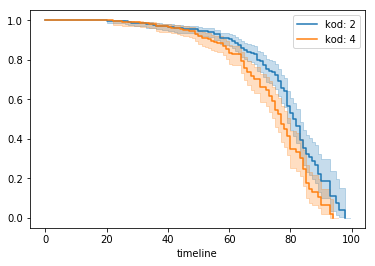

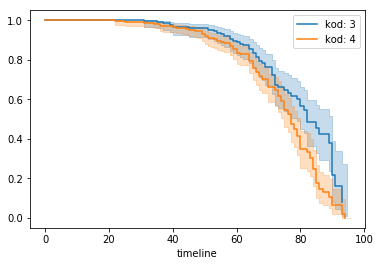

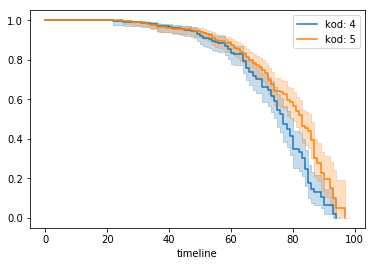

In [168]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
sidak = 1 - (1 - 0.05)**(1/10)
bonf = 0.05 / 10
print("Poziom istotności po poprawce Šidaka: " + str(sidak))
print("Poziom istotności po poprawce Bonferroniego: " + str(bonf))
for i in range(1,5):
    for j in range(2,6):
        if i<j:
            T1 = dd[i]['age']
            E1 = dd[i]['E']
            kmf1.fit(T1, E1, label='kod: ' + str(i))

            T2 = dd[j]['age']
            E2 = dd[j]['E']
            kmf2.fit(T2, E2, label='kod: ' + str(j))
            results = logrank_test(T1, T2, 
                                   event_observed_A=E1, 
                                   event_observed_B=E2)
            if(results.p_value < sidak):
                print("p-value po poprawce Šidaka:", 
                      str(i), "i", str(j))
                print(results.p_value)
                ax = kmf1.plot()
                kmf2.plot(ax=ax)
                if(results.p_value < bonf):
                    print("p-value po poprawce Bonferroniego:", 
                          str(i), "i", str(j))
                    print(results.p_value)

Dla par kodów dyscyplin: 2 i 4, 3 i 4, 4 i 5, odrzucona została hipoteza zerowa zakładająca, że nie ma różnicy w funkcji przeżycia dla danej pary grup dyscyplin.

W przypadku porównania grup dyscyplin 2 i 4, czyli dyscyplin siłowo-wytrzymałościowych i dyscyplin siłowych, uprawianie dyscyplin siłowych wpływa na skrócenie czasu trwania życia.
Taki rezultat otrzymano dla porównania grup 3 i 4, czyli dyscyplin szybkościowo-siłowych i dyscyplin siłowych, a także porównania grup 5 i 4, czyli lekkoatletyki z dyscyplinami siłowymi, dla każdego z porównań uprawianie dyscyplin siłowych wpływa na skrócenie długości trwania życia. W przypadku pozostałych 7 porównań, różnica funkcji przeżycia między grupami nie jest istotna statystycznie.

Wielowymiarowy test logrank nie wykazał, że w ramach jednej płci jest różnica statystyczna między grupami dyscyplin, dlatego nie przeprowadzono dalszych testów.

## ANOVA

Analiza wariancji (ANOVA) pozwala na wyjaśnienie, z jakim prawdopodobieństwem wyodrębniony czynnik (bądź czynniki w przypadku wieloczynnikowej analizy wariancji) ma wpływ na różnice między średnimi w grupach. W naszym przypadku tym czynnikiem jest grupa dyscyplin. ANOVA nie może być użyta dla danych urywanych, średnia w grupach nie jest dla nich znana, dlatego analiza będzie przeprowadzona dla struktury d1, w której znajdują się informacje o sportowcach, którzy nie żyją.

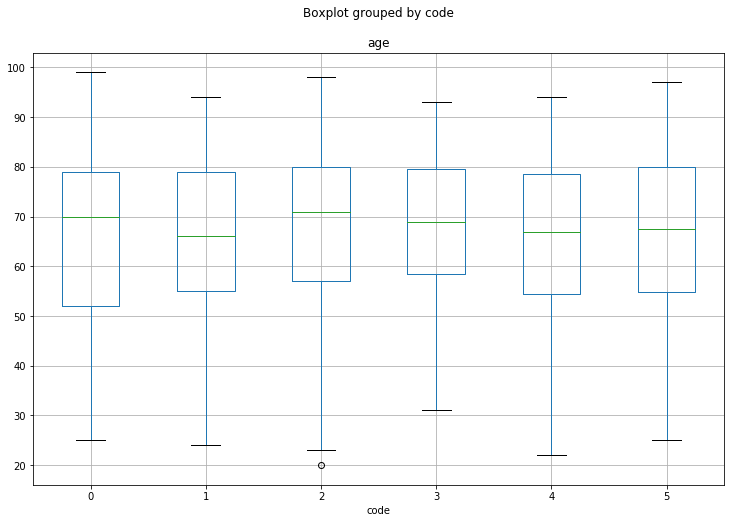

In [172]:
d1.boxplot('age', by='code', figsize=(12, 8))

Na wykresie zostały przedstawione rozkłady liczby lat życia dla grup dyscyplin.

Pierwszym krokiem w analizie wariancji jest obliczenie sumy kwadratów wewnątrz grup (ozn. SSW). Dla każdej z grupy obliczona będzie średnia liczba lat życia. Następnie, dla każdej obserwacji wewnątrz danej grupy będzie obliczony kwadrat różnicy między tą obserwacją a średnią liczby lat życia tej grupy. Suma tych wartości to suma kwadratów wewnątrz grupy. SSW to suma sum kwadratów wewnątrz grupy. W liście sumsq przechowywane są wartości sum kwadratów wewnątrz każdej z grup. Zmienna means przechowuje wartości średnich liczby lat życia dla grup.

In [193]:
means = d1.groupby('code')['age'].mean()
means

code
0    65.681529
1    65.478723
2    66.575000
3    67.381818
4    65.591304
5    65.641667
Name: age, dtype: float64

In [183]:
sumsq = []
for grp in d1.groupby('code')['age']:
    sumsq.append(sum([(value - means[grp[0]])**2 
                      for value in grp[1].values]))
SSW = sum(sumsq)

In [197]:
SSW

217642.68111593436

Następnym krokiem jest obliczenie całkowitej sumy kwadratów (ozn. SST). Do jej obliczenia niezbędne jest policzenie średniej ze wszystkich obserwacji. Następnie dla każdej obserwacji obliczany jest kwadrat różnicy tej obserwacji i średniej ze wszystkich obserwacji. SST to suma tych wartości. Zmienna mean_total przechowuje wartość średniej ze wszystkich obserwacji.

In [201]:
mean_total = d1['age'].mean()
mean_total

65.87682119205299

In [203]:
SST = sum([(value - mean_total)**2 
           for value in d1['age'].values])
SST

217877.5443708607

Kolejnym krokiem jest obliczenie wartości średniej między grupami (ozn. SSB). Ta wartość to różnica całkowitej sumy kwadratów i sumy kwadratów wewnątrz grup.

In [205]:
SSB = SST - SSW
SSB

234.86325492634205

Następnie obliczone jest tzw. F ratio. Do jego obliczenia potrzebne są dodatkowo: liczba stopni swobody dla grup (liczba grup - 1, w naszym przypadku 5) i liczba stopni swobody wewnątrz grup (liczba obserwacji - liczba grup). 

In [208]:
len(d1) - 6

749

Liczba stopni swobody wewnątrz grup wynosi 749. Mamy już wszystkie niezbędne wartości, żeby obliczyć F ratio.

In [211]:
F_ratio= (SSB/5)/(SSW/749)
print(F_ratio)

0.1616526473923786


Jeżeli obliczone F ratio jest wyższe od wartości krytycznej dla danych parametrów (stopni swobody dla grup i wewnątrz grup), możemy odrzucić hipotezę zerową, która zakłada, że grupy się między sobą nie różnią. Wartość krytyczną dla danych parametrów możemy znaleźć, korzystając z pakietu scipy.stats.

In [215]:
from scipy.stats import f
f.ppf(q=1-0.05, dfn=5, dfd=749)

2.2260609766925414

Wartość krytyczna to 2,2260609766925414, jest ona wyższa niż obliczony współczynnik F ratio, więc nie możemy odrzucić hipotezy zerowej.

## H-test Kruskala-Wallisa

Alternatywą dla jednoczynnikowej analizy wariancji może być H-test Kruskala-Wallisa, który bierze pod uwagę medianę. Implementacja testu także znajduje się w pakiecie scipy.stats. Medianę dla danej grupy można policzyć, jeżeli co najmniej połowa sportowców z tej grupy już nie żyje. Dla osób urodzonych przed rokiem 1952, dla każdej z grup (elementów listy dd), ponad połowa sportowców umarła i możliwe jest obliczenie mediany.

In [223]:
lens= [sum(val[val['born']<1952]['died']!=0)/
       len(val[val['born']<1952]) for val in dd]
lens

[0.5769230769230769,
 0.567741935483871,
 0.54,
 0.5212765957446809,
 0.6917808219178082,
 0.5450236966824644]

Następnie, korzystając z pakietu scipy.stats, obliczone zostały statystyka testu i p-value.

In [229]:
from scipy.stats import kruskal
kruskal(dd[0]['age'][dd[0]['born']<1952], 
        dd[1]['age'][dd[1]['born']<1952],
        dd[2]['age'][dd[2]['born']<1952], 
        dd[3]['age'][dd[3]['born']<1952],
        dd[4]['age'][dd[4]['born']<1952], 
        dd[5]['age'][dd[5]['born']<1952])

KruskalResult(statistic=13.60935464208207, pvalue=0.018290832999052292)

Wartość współczynnika p-value jest mniejsza od wartości 0,05, co pozwala na odrzucenie hipotezy zerowej, która zakłada, że nie ma różnicy między żadną z grup. Test wykazał, że między grupami jest różnica, natomiast nie wskazał, między którymi z nich. W tym celu przeprowadzony został test Conovera-Imana, który jest dostępny w pakiecie conover.test w języku R. Test porównuje między sobą pary, dlatego przeprowadzono go z poprawką Šidaka.

In [ ]:
> conover.test(x=list(l.0, l.1, l.2, l.3, l.4, l.5), 
               method="sidak", alpha=0.05)
  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 12.8806, df = 5, p-value = 0.02


                           Comparison of x by group                            
                                    (Šidák)                                    
Col Mean-|
Row Mean |          0          1          2          3          4
---------+-------------------------------------------------------
       1 |   1.812013
         |     0.4150
         |
       2 |  -0.775893  -2.485286
         |     0.9755     0.0937
         |
       3 |  -1.526003  -2.857421  -0.883814
         |     0.6270     0.0321*    0.9564
         |
       4 |   1.141822  -0.343323   1.755889   2.283492
         |     0.8693     0.9989     0.4552     0.1566
         |
       5 |  -0.250516  -1.967936   0.504326   1.293410  -1.312859
         |     0.9995     0.3123     0.9959     0.7873     0.7753

alpha = 0.05
Reject Ho if p <= alpha/2

Test wykazał statystycznie istotną różnicę dla grup dyscyplin: 1 i 3, czyli dla dyscyplin wytrzymałościowych i dyscyplin wytrzymałościowo-siłowych.

## Porównanie według daty urodzenia

### Porównanie osób urodzonych przed wojną i po wojnie

Za pomocą estymatora Kaplana-Meiera porównane zostały funkcje przeżycia dla osób urodzonych przed II wojną światową i po II wojnie światowej (odpowiednio db i da).

In [240]:
db = d[d.born<1939]
da = d[d.born>1945]

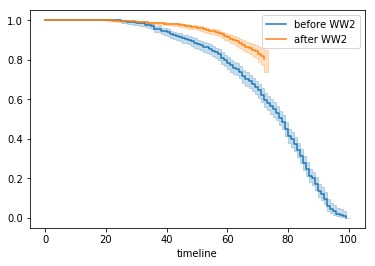

In [241]:
T1 = db['age']
E1 = db['E']
kmf1.fit(T1, E1, label='before WW2')

T2 = da['age']
E2 = da['E']
kmf2.fit(T2, E2, label='after WW2')
ax = kmf1.plot()
kmf2.plot(ax=ax)

In [239]:
results = logrank_test(T1, T2, 
                       event_observed_A=E1, 
                       event_observed_B=E2)
results.print_summary()

print(results.test_statistic) 
print("p-value:",results.p_value)


df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p     
       72.1384 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
72.13841454779532
p-value: 2.006200857215174e-17


Współczynnik p-value ma wartość niższą od 0,05, więc możemy odrzucić hipotezę zerową, że funkcje przeżycia się między sobą nie różnią. Sportowcy urodzeni po II wojnie światowej częściej dożywają późnego wieku. 

### Porównanie osób urodzonych w różnych dekadach

W strukturze d dodana została kolumna z informacją o dekadzie, w której urodził się sportowiec. Dla osób urodzonych przed rokiem 1900, w kolumnie została wpisana wartość -1.

In [331]:
d['decade'] = d['born'].apply(lambda x: int(str(x)[2]) 
                              if x>=1900 else -1)
d[['born', 'decade']].sample(5)

,born,decade
1058,1937,3
1300,1982,8
2555,1980,8
1680,1951,5
1242,1972,7


Następnie został przeprowadzony wielowymiarowy test logrank.

In [244]:
results = multivariate_logrank_test(d['age'], 
                                    d['decade'], d['E'])
results.print_summary()
print(results.p_value)


df=10, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p     
      152.6334 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
1.070034056189435e-27


Test wykazał, że hipoteza zerowa może zostać odrzucona. Następnie, podobnie jak w przypadku grup dyscyplin, porównane zostały parami dekady urodzenia (zastosowano poprawkę Šidaka). Dekad jest 11 (od -1 do 9), więc przeprowadzone zostało 11*10/2=55 testów.

In [260]:
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
sidak = 1 - (1 - 0.05)**(1/55)
for i in range(-1,9):
    for j in range(0,10):
        if i<j:
            T1 = d[d.decade == i]['age']
            E1 = d[d.decade == i]['E']
            kmf1.fit(T1, E1, label='dekada: ' + str(i)) 

            T2 = d[d.decade == j]['age']
            E2 = d[d.decade == j]['E']
            kmf2.fit(T2, E2, label='dekada: ' + str(j)) 
            results = logrank_test(T1, T2, 
                                   event_observed_A=E1, 
                                   event_observed_B=E2)
            
            if(results.p_value < sidak):
                print("p-value dla dekad: " + str(i), 
                      str(j)+":", results.p_value)

p-value dla dekad: -1 3: 3.119150137392707e-08
p-value dla dekad: -1 4: 1.7476804233900628e-10
p-value dla dekad: -1 5: 1.466547435659776e-14
p-value dla dekad: -1 6: 1.2382735413606939e-10
p-value dla dekad: -1 7: 7.695886146747544e-06
p-value dla dekad: 0 2: 0.00013388484998592956
p-value dla dekad: 0 3: 1.3809638280742153e-10
p-value dla dekad: 0 4: 5.491298327800608e-13
p-value dla dekad: 0 5: 3.905591723020405e-17
p-value dla dekad: 0 6: 1.8548402686588976e-13
p-value dla dekad: 0 7: 2.335776456508315e-14
p-value dla dekad: 0 8: 0.00029706729765654083
p-value dla dekad: 1 3: 3.837892381955413e-05
p-value dla dekad: 1 4: 1.1505608996475454e-06
p-value dla dekad: 1 5: 4.936725724936925e-08
p-value dla dekad: 1 6: 0.0002085958317712735
p-value dla dekad: 1 7: 8.745135522210999e-05
p-value dla dekad: 1 8: 0.0008783753732650011
p-value dla dekad: 2 5: 0.0008601267368949629


Wartość p-value dla wyodrębnionych przypadków jest niższa niż wartość poziomu istotności po poprawce Šidaka, dlatego możemy odrzucić hipotezę zerową. Zgodnie z przewidywaniami, różnice istotne statystycznie występują głównie między dekadami z początku XX wieku a późniejszymi z dekad. Można zauważyć, że nie występuje różnica istotna statystycznie między dwiema dekadami następującymi po sobie.

### Badanie wpływu roku urodzenia na długość życia

Do zbadania zależności między rokiem urodzenia a długością życia, posłużono się korelacją Spearmana. Korelacja Spearmana jest miarą monotonicznej zależności statystycznej między zmiennymi losowymi. Korelacja Spearmana jest zaimplementowana w pakiecie scipy.stats. Hipoteza zerowa zakłada, że zmienne są nieskorelowane. W teście wzięto pod uwagę dane sportowców, którzy już nie żyją.

In [261]:
import math
from scipy.stats import spearmanr

In [326]:
print("p-value:", spearmanr(d1['age'],d1['born'])[1])

p-value: 3.651105065175587e-15


Wartość p-value jest bliska zeru, więc możemy wykluczyć hipotezę zerową. Potwierdza to przypuszczenie, że liczba lat życia i rok urodzenia są ze sobą ujemnie skorelowane.

# Wnioski

Analiza przeżycia wykazała, że istnieje istotna statystycznie różnica w funkcji przeżycia między sportowcami uprawiającymi dyscypliny siłowe a sportowcami uprawiającymi dyscypliny siłowo-wytrzymałościowe, szybkościowo-siłowe i lekkoatletykę. W każdym z tych przypadków pokazano, że uprawianie dyscyplin siłowych wpływa na skrócenie długości trwania życia. Nie wykazano istotnych statystycznie różnic dla pozostałych par dyscyplin. W ramach płci (kobiety, mężczyźni) nie wykazano różnic statystycznych między sportowcami uprawiającymi dyscypliny należące do różnych grup. Należy przy tym mieć na uwadze, że niewielki odsetek kobiet uprawia dyscypliny siłowe, co mogło mieć wpływ na wynik analizy.
Dla osób, które nie żyją (755 osób, mniej niż 1/3 wszystkich olimpijczyków), przeprowadzono oddzielną analizę i nie wykazano zależności między uprawianą dyscypliną sportu a długością życia.
Wykazano także istotną statystycznie różnicę dla sportowców uprawiających dyscypliny wytrzymałościowe i dyscypliny wytrzymałościowo-siłowe na grupie osób urodzonych przed 1952 rokiem. Jest to grupa osób, dla której (niezależnie od wybranej grupy dyscyplin) co najmniej połowa sportowców nie żyje.
Zbadano także wpływ daty urodzenia na długość życia. Pokazano, że osoby urodzone przed II wojną światową rzadziej dożywają późnych lat niż osoby urodzone po II wojnie światowej. Wykazano także, że istnieją różnice istotne statystyczne dla osób urodzonych w różnych dekadach, osoby urodzone we wcześniejszych dekadach żyją statystycznie krócej niż osoby urodzone w późniejszych dekadach.
Na długość życia wśród sportowców wpływa także rok urodzenia. Pokazano, że jest on ujemnie skorelowany z długością życia i im wyższy rok urodzenia, tym dłuższa liczba przeżywanych lat.